In [20]:
# Homework 3 (due 07/16/2024)

# Eigenbears

## Instructions

#### Part 1: Data preparation (ALREADY COMPLETED)
The folder that contains this notebook also contains a data set of pictures of pandas and brown bears. 
1. Load the images for train and test.
2. Reduce their size/resolution by 50%.
3. Convert the colors to grey scale.
4. Display a few of the images. 

#### Part 2: Singular value decomposition (FOR YOU TO COMPLETE)
1. Follow the steps in the eigenfaces tutorial from the UW databook [[link]](https://github.com/dynamicslab/databook_python/blob/master/CH01/CH01_SEC06_2_3_4.ipynb) to perform an SVD on the images.
2. Note that you will need to "center the data" before doing the SVD. Data centering means replacing each variable $X_i$ with a new variable $X_i'$ that is equal to $X_i$ minus $X_i$'s mean value. (Think carefully about whether you want to use the mean of train set, test set, or the full data set for this.)
3. Display the first four "eigenbears" (i.e., the images associated with the first four eigenvectors). Explain what you see.
4. The singular vectors are sometimes called "principal components". Principal component analysis (PCA) is a data analysis method for which one projects high-dimensional data into the subspace of the first two singular vectors. Use the code scaffold provided below do perform PCA for the bears data. What do you notice?

#### Part 3: Non-parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

#### Part 4: Parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Try using logistic regression and LDA to classify the bears. 
2. What method gives you the best test accuracy? 
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

--------------------------------

In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, time
import scipy
from sklearn.decomposition import PCA

## Part 1: Data preparation

In [22]:
# toggle settings
add_noise = True

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)
    

    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')
        
        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):
            
            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1
                
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
    
                # import image
                image = plt.imread(file_path, format='jpeg')
    
                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)
    
                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


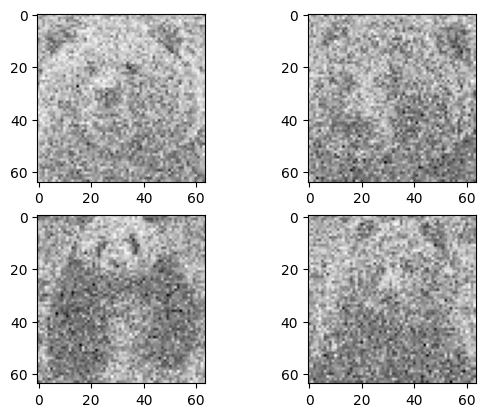

In [23]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

# Part 2: Singular value decomposition

In [24]:
# Construct data matrix of centered data
'''ADD SOME CODE HERE'''

train_cols = []

for image in train_images:
    flat_image = np.array(image).flatten()
    train_cols += [flat_image]
    
train_mat = np.column_stack(train_cols)
    
mean_image = np.mean(train_mat, axis=1, keepdims=True)

X = train_mat - mean_image


test_cols = []

for image in test_images:
    flat_image = np.array(image).flatten()
    test_cols += [flat_image]
    
test_mat = np.column_stack(test_cols)
    
mean_test_image = np.mean(test_mat)
    
X_test = test_mat - mean_test_image




# Perform SVD
U, S, Vh = np.linalg.svd(X) 

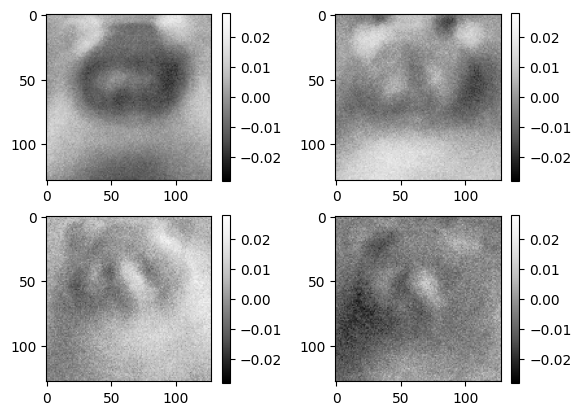

In [25]:
# show the first four eigenbears
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow((U[:,i]).reshape((128,128)), cmap='Greys_r',
        # force colormap to be the same for all four
        vmin=-np.max(np.abs(U[:,:4])),
        vmax=np.max(np.abs(U[:,:4])))
    plt.colorbar()
plt.subplots_adjust(wspace=0.4)



Here we can see the very rough outlines of the bears. We can see the outline of the head, the ears, and the eyes, but not much else. It is also very blurry.

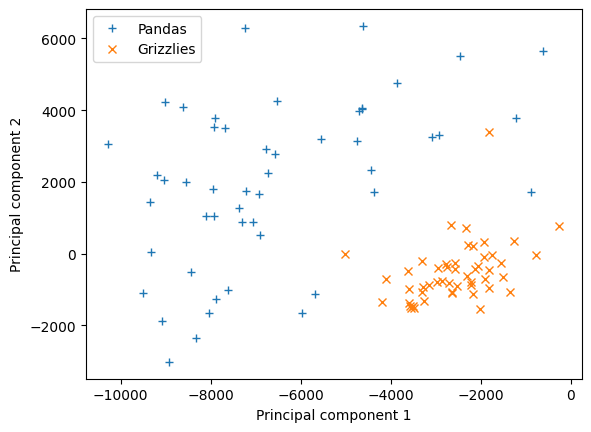

In [26]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:,0],np.ravel(test_images[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images[x])) for x in indices]
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Grizzlies'][i])

# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# add legend
plt.legend()

Above we can clearly see that there is clustering along the first and second axis. The grizzlies are a lot more concentrated — this could be because they are all one color so there is less variation between the two of them?

In [40]:
# Perform PCA 

pca = PCA()
pca.fit(X)

# looking at the output from this statement, we see that the explained variance goes down with each dimension which is what we want to see from PCA!
print(pca.explained_variance_ratio_)

pca.fit_transform(X)


[0.03697911 0.02661159 0.01549276 0.01178784 0.0098217  0.00848464
 0.00779492 0.00687867 0.00674981 0.00644925 0.00632572 0.00601912
 0.00561915 0.00530197 0.00501157 0.00486328 0.00464812 0.00456339
 0.00419173 0.00406962 0.00390583 0.00366111 0.00361478 0.00354595
 0.00339965 0.00339222 0.00334492 0.00323529 0.00319305 0.00312853
 0.00300993 0.00299895 0.00293052 0.00292456 0.00289938 0.00286419
 0.00283807 0.00279587 0.00278267 0.0027124  0.00266238 0.00265438
 0.00262207 0.00261733 0.0025953  0.00254807 0.00253975 0.00250821
 0.00249029 0.00247252 0.00244665 0.0024209  0.00240363 0.00239996
 0.00239009 0.00236545 0.00235377 0.00233914 0.00232816 0.00231672
 0.00231503 0.0022885  0.00228144 0.00227275 0.00226936 0.00225488
 0.00224373 0.00222851 0.0022168  0.00221383 0.00220478 0.00219736
 0.00219269 0.00218764 0.00218347 0.00216691 0.00216232 0.00215425
 0.00214864 0.00213562 0.00213233 0.00212838 0.00212401 0.00211963
 0.00211142 0.00210497 0.00210055 0.00209401 0.00208751 0.0020

array([[ 6.29503878e+02, -3.53291648e+02, -9.88133839e+01, ...,
         2.04092095e+01, -1.26357365e+02, -1.61815006e-13],
       [ 5.08580817e+02, -3.27953030e+02, -4.09913118e+01, ...,
         9.35818667e+01, -9.26240811e+01,  9.39803790e-14],
       [ 4.41153864e+02, -1.54634498e+02, -1.25754684e+02, ...,
         2.44351678e+01, -1.94249552e+01, -1.90236715e-13],
       ...,
       [ 1.34939891e+02,  4.03003776e+02, -1.14284294e+02, ...,
         4.20773079e+01, -7.72263610e+01,  5.13478149e-14],
       [-3.70232636e+01,  3.59505264e+02, -3.53171098e+02, ...,
         6.04711611e+01,  1.07092888e+02,  6.62414568e-13],
       [-1.80840550e+02,  3.73478893e+02, -3.50610819e+01, ...,
        -6.78040284e+00, -9.37506793e+01,  2.64510636e-13]])

# Part 3: Nonparametric classification

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.
y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the 
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

In [29]:
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')
misclassified_bears = []
for k in range(1,16):
    # fit KNN model
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(X.T, y_train)
    # use model to make predictions on the test set
    predictions = [modelKN.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]
    # detect misclassifications
    errors = np.abs((np.array(predictions).T)[0]-y_test)
    # print results to table
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errors)), (np.argwhere(errors).T)[0]))
    
    misclassified_bears.append((np.argwhere(errors).T)[0])
    
print(misclassified_bears)
    

   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      8 	| [ 6  8 21 22 24 39 41 42]
    2	|      7 	| [ 8 21 22 24 39 41 42]
    3	|      10 	| [ 6  8  9 21 22 24 32 39 41 42]
    4	|      6 	| [ 8 21 22 39 41 42]
    5	|      8 	| [ 6  8 21 22 32 39 41 42]
    6	|      5 	| [21 22 39 41 42]
    7	|      10 	| [ 5  8 21 22 24 32 36 39 41 42]
    8	|      6 	| [ 5 21 32 39 41 42]
    9	|      8 	| [ 5 21 22 24 32 39 41 42]
    10	|      6 	| [ 5 21 32 39 41 42]
    11	|      7 	| [ 5 21 22 32 39 41 42]
    12	|      6 	| [ 5 21 32 39 41 42]
    13	|      7 	| [ 5 21 22 32 39 41 42]
    14	|      7 	| [ 5 21 22 32 39 41 42]
    15	|      7 	| [ 5 21 22 32 39 41 42]
[array([ 6,  8, 21, 22, 24, 39, 41, 42]), array([ 8, 21, 22, 24, 39, 41, 42]), array([ 6,  8,  9, 21, 22, 24, 32, 39, 41, 42]), array([ 8, 21, 22, 39, 41, 42]), array([ 6,  8, 21, 22, 32, 39, 41, 42]), array([21, 22, 39, 41, 42]), array([ 5,  8, 21, 22, 24, 32, 36, 39, 41, 42]), arra

Looking at the above bears, the best classification came when k=6, with only 5 errors. This is also promising because it is a relatively small number for k, which will make our regression run faster. The most common hard-to classify bears are

{6: 3, 8: 6, 21: 15, 22: 12, 24: 5, 39: 15, 41: 15, 42: 15, 9: 1, 32: 11, 5: 9, 36: 1}


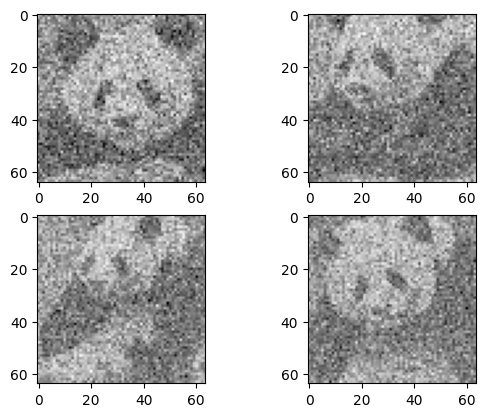

In [30]:
# Show hard-to-classify bears
'''ADD SOME CODE'''
misclassified_bears_count = {}
for array in misclassified_bears:
    for bear in array:
        if bear not in misclassified_bears_count.keys():
            misclassified_bears_count[bear] = 1
        else: 
            misclassified_bears_count[bear] += 1

print(misclassified_bears_count)
# from the output, we can see that the 6 most misclassified bears were 21, 42, 39, 41, 5, 32

bears = [21, 42, 39, 41, 5, 32] 

for i in range(len(bears)): 
    num = i % 4
    plt.subplot(2,2,1+num)
    plt.imshow(train_images[i][::2,::2], cmap='Greys_r')
    

    

# now display them: 

    
        

We can see in these photos that all the bears do not have distinguished coloring on their coats. It is also notable that the computer got them wrong between 13-15 times out of the 15 iterations, which means it was fairly confident that they were the opposite classification than they actually were. 

# Part 4: Parametric classification

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis




In [32]:
'''ADD SOME CODE'''

logReg = LogisticRegression()
results = logReg.fit(X.T, y_train)

test_result = logReg.predict(X_test.T)



correct = 0
incorrect = 0
for i in range(len(test_result)):
    if test_result[i] == y_test[i]: 
        correct += 1
    else: 
        incorrect += 1
        

print("percent correct: ", correct/len(test_result))



percent correct:  0.99


Above we can clearly see that logistic regression is an excellent predictor of pandas vs bears, with a  99% accuracy on the test set of images (this means it only got one wrong)

In [33]:
# Do lDA: 

lda = LinearDiscriminantAnalysis()
lda.fit(X.T, y_train)

correct = 0
incorrect = 0

lda_result = lda.predict(X_test.T)
for i in range(len(lda_result)):
    if lda_result[i] == y_test[i]: 
        correct += 1
    else: 
        incorrect += 1
        
print("percent correct: ", correct/len(lda_result))



# One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.



percent correct:  0.98


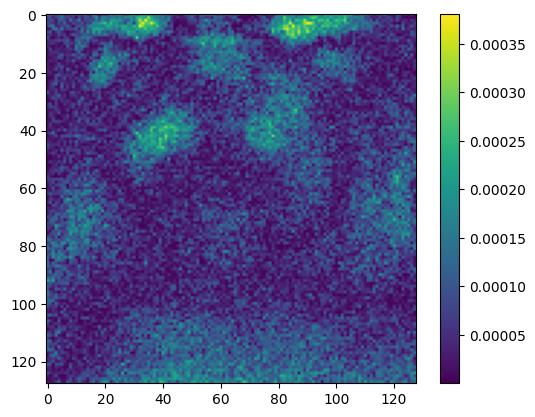

In [34]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((logReg.coef_).reshape((128,128))))
plt.colorbar()

The above plot shows us which pixels in each image are the greatest contributors. We can see that the more yellow/green pixels are around the area where the ears, eyes, and nose would be in the bears. This makes a lot of sense because they are the distinguishing features of a bears, so it is good that the logistic regression is using them to predict the type of bear. 

Part 5: #### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

Looking at the results of adding noise, the images appeared a lot blurrier, but the regressions all predicted with the same or better accuracy. The k-nearest neighbors had the same results, with 6 variables being the most accurate with 5 errors (95% accuracy, the regression model predicted the same 99% accuracy, and the LDA went up from 96 to 96 % accuracy. This result on the accuracy comes from the fact that adding nose reduces the potential for overfitting. When there is noise around the pixels, a variation in one pixel on one bear is less likely to impact the model. 

The additive noise makes the eigenbears a little bit blurrier but also more distinguishable from what is a panda vs brown bear. The bear mask is also a lot more clearly a bear face, with the brighter colors still acting as the eyes/ears/nose. While the actual pictures are a lot more blurry, the results of eigenbears and bear mask are clearer. 

Other types of noise that might impact the classification results differently could be too much noise where the model can no longer distinguish key features. Additionally, if the noise is too black/white or intensifies the radiance of each pixel this could have the opposite affect becasue the model would start over fitting using the brighter pixels. 